## Helper Methods
- Tools we may use later for data pre-processing and graphing

In [98]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from pathlib import Path
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, concatenate, Lambda, BatchNormalization, Activation, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt 
from collections.abc import Sequence
from sklearn import preprocessing
%matplotlib inline
from IPython.display import Image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preproc
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort = True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by = ['y'],inplace = True)
    a = plt.plot(t['pred'].tolist(), ls = '', marker='s', markersize = 1.0, label = 'prediction', color = 'orange')
    b = plt.plot(t['y'].tolist(), label = 'expected', color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
#custom function for sliding window x/y data split
def create_sliding_window_data(df, close_unnormalized, window_size):
    x = []
    y = []
    for i in range(window_size, len(df)):
        #get window_size days of data (rows i-window_size to i-1)
        window = df.iloc[i-window_size:i].values
        x.append(window.flatten())
        y.append(close_unnormalized[i])
    return np.array(x), np.array(y)


## Set up Environment
Create test output folders and define paths 

In [99]:
base_path=os.path.join(os.getcwd(), 'test-output/')

iteration='iteration-1'
full_path = os.path.join(base_path, iteration)
try:
        os.mkdir(base_path)
except Exception as e:
     print(f"Probably safe to ignore the following error: \n{e}")

#try:
#    os.mkdir(full_path)
#except Exception as e:
#    print(f"{e}\nExiting to protect previous work.")
#    sys.exit(0)
    

Probably safe to ignore the following error: 
[Errno 17] File exists: '/Users/nyess/Desktop/VSCode/Python/Assignment4/bchurch2-Time-Series-Forecasting/test-output/'


## Data Extraction

In [100]:
#read dataset and format
TXT_DATASET_LOCATION = "./business-dataset/AAPL.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)

#normalize data (separate from close_unnormalized)
for col in df.columns:
    encode_numeric_zscore(df, col)

## Data Split

In [101]:
#XY split
x, y = create_sliding_window_data(df, close_unnormalized, window_size=7)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

## FCNN Model


In [102]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights1.keras", verbose = 0, save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(5):
    print(i)
    #build the network
    model = Sequential()
    model.add(Dense(64, input_dim = x.shape[1], activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
   

    #model compilation
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, batch_size = 64, callbacks = [monitor, checkpointer], verbose = 1)
    print('Training finished...Loading the best model')  
    print()

0
Epoch 1/1000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2680.8669 - val_loss: 2714.9277
Epoch 2/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 2536.3813 - val_loss: 2506.7805
Epoch 3/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 2284.0886 - val_loss: 2159.3828
Epoch 4/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1834.1471 - val_loss: 1585.6079
Epoch 5/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1139.8214 - val_loss: 763.1795
Epoch 6/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 483.3024 - val_loss: 189.3234
Epoch 7/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 171.6815 - val_loss: 54.9250
Epoch 8/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 127.2912 - val_loss: 44.5768
Epoch 9/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 128.6309 - val_loss: 42.0943
Epoch 10/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 134.9672 - val_loss: 42.8679
Epoch 11/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 122.

In [103]:
model.load_weights('./dnn/best_FCNNweights1.keras')

## FCNN Graphing

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
(2865, 1)
Score (RMSE): 1.6752068724606637


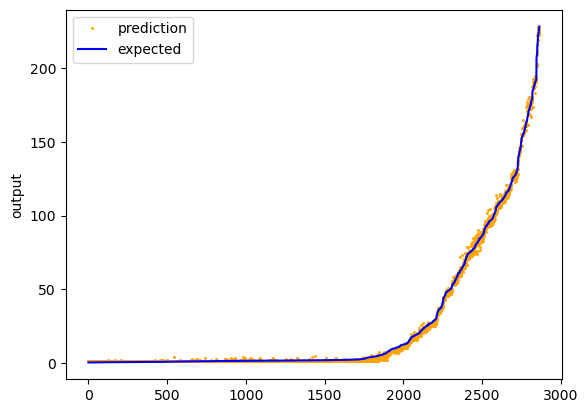

In [104]:
#make predictions
y_pred = model.predict(x_test)
print(y_pred.shape)

#rmse score
score = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
print("Score (RMSE): {}".format(score))
chart_regression(y_pred.flatten(),y_test, sort = True)

## CNN Model


In [ ]:

#save the best model
CNNcheckpointer = ModelCheckpoint(filepath="./dnn/best_CNNweights.keras", verbose = 0, save_best_only = True) 

#reshape for CNN
#Not certain if this is the best approach, mainly just done to avoid error
x_train = x_train.reshape(-1, 7, 5, 1)
x_test  = x_test.reshape(-1, 7, 5, 1)

#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network

    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(7, 5, 1)))
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.25))

    CNN_model.add(Flatten())
    CNN_model.add(Dense(64, activation="relu"))
    CNN_model.add(Dropout(0.25))
    CNN_model.add(Dense(1, activation="linear"))
    

#model compilation
CNN_model.compile(loss = 'mean_squared_error', optimizer = optimizer)
#early stopping
monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
#optimizer
optimizer = Adam(learning_rate = 0.0001)

#train model

# Train correct model
history = CNN_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    batch_size=64,
    callbacks=[CNNcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0
Epoch 1/100


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2644.2317 - val_loss: 2541.5310
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1700.1763 - val_loss: 633.8832
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 203.6466 - val_loss: 39.5232
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.6914 - val_loss: 30.9449
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79.1856 - val_loss: 27.6432
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.1260 - val_loss: 24.9953
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.3500 - val_loss: 22.5268
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.6284 - val_loss: 20.0141
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.1591 - val_loss: 17.0830
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.6930 - val_loss: 15.1552
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.6415 - val_loss: 12.3363
Epoch 12/100
105/105 ━━

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
(2865, 1)
Score (RMSE): 1.6479978034018032


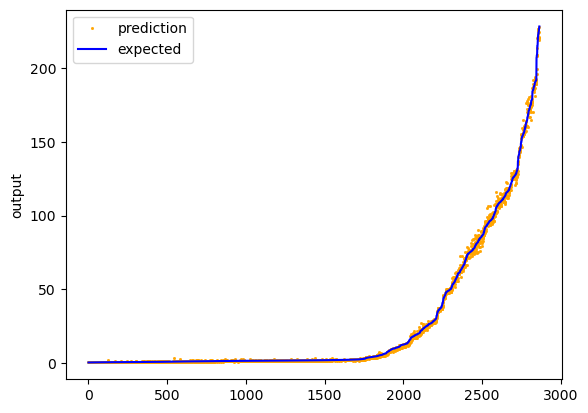

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 5, 3, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_385 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,413 (318.02 KB)

 Trainable params: 27,137 (106.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,276 (212.02 KB)

In [106]:
CNN_model.load_weights('./dnn/best_CNNweights.keras')
y_other_pred = CNN_model.predict(x_test)
print(y_other_pred.shape)

#rmse score
score = np.sqrt(metrics.mean_squared_error(y_test,y_other_pred))
print("Score (RMSE): {}".format(score))
chart_regression(y_other_pred.flatten(),y_test, sort = True)
CNN_model.summary()

## LSTM Model

In [107]:
#save the best model

#LSTM checkpoint
LSTMcheckpointer = ModelCheckpoint(filepath="./dnn/best_LSTMweights.keras", verbose = 0, save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(5):
    print(i)
    #build the network
    LSTM_model = Sequential()

    LSTM_model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(1, 35)))
    LSTM_model.add(Dropout(0.3))
    LSTM_model.add(Dense(32, activation = "relu"))
    LSTM_model.add(Dropout(0.2))
    LSTM_model.add(Dense(16, activation = "relu"))
    LSTM_model.add(Dense(1, activation = "linear"))
   

    #model compilation
    LSTM_model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model

# Reshape for LSTM
x_train = x_train.reshape(x_train.shape[0], 1, 35)
x_test = x_test.reshape(x_test.shape[0], 1, 35)

# Train correct model
history = LSTM_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    batch_size=64,
    callbacks=[LSTMcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0
1
2
3
4
Epoch 1/1000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2690.2012 - val_loss: 2741.7319
Epoch 2/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2517.9382 - val_loss: 2422.6301
Epoch 3/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2025.7799 - val_loss: 1653.7267
Epoch 4/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1178.7268 - val_loss: 717.4787
Epoch 5/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 494.9742 - val_loss: 232.3122
Epoch 6/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 285.6201 - val_loss: 165.9229
Epoch 7/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 268.1879 - val_loss: 149.6907
Epoch 8/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 240.3313 - val_loss: 134.6567
Epoch 9/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 242.9814 - val_loss: 122.7565
Epoch 10/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 218.3383 - val_loss: 105.4425
Epoch 11/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 213.7339 - val_loss: 9

In [108]:
x_train[1:4]

array([[[-0.51997471, -0.51978795, -0.51893908, -0.3245618 ,
         -0.51928004, -0.51880879, -0.51843898, -0.51815516,
         -0.31444372, -0.51889147, -0.51822585, -0.51824628,
         -0.51756721, -0.30519566, -0.51772574, -0.51783719,
         -0.51805356, -0.5167833 , -0.38575364, -0.51714289,
         -0.51880879, -0.51940253, -0.51952702,  0.48140469,
         -0.51947433, -0.51919742, -0.51998067, -0.51991898,
          0.08950622, -0.52064004, -0.52094631, -0.52190778,
         -0.52148684,  0.34535837, -0.52219435]],

       [[-0.52585285, -0.52638828, -0.52472051, -0.21097505,
         -0.52564293, -0.52563428, -0.52436483, -0.52452454,
          0.08447941, -0.52345719, -0.52332672, -0.52330492,
         -0.5227117 , -0.02230825, -0.52272862, -0.52284091,
         -0.52359399, -0.52246674, -0.58060729, -0.52350576,
         -0.5234482 , -0.5233531 , -0.52251573, -0.65407617,
         -0.52272862, -0.52313239, -0.52277496, -0.52202577,
          0.29573466, -0.52190291,

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(2865, 1)
Score (RMSE): 2.6981570057655344


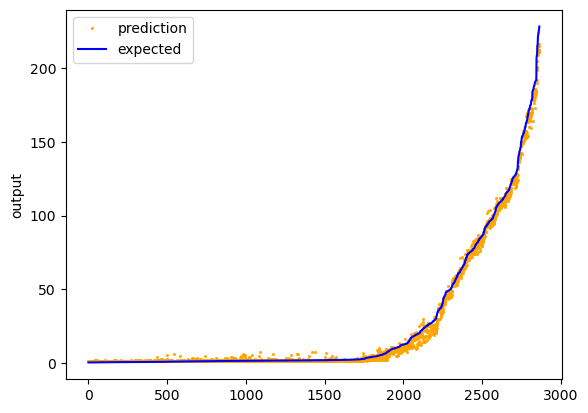

In [109]:
LSTM_model.load_weights('./dnn/best_LSTMweights.keras')
y_other_pred = LSTM_model.predict(x_test)
print(y_other_pred.shape)

#rmse score
score = np.sqrt(metrics.mean_squared_error(y_test,y_other_pred))
print("Score (RMSE): {}".format(score))
chart_regression(y_other_pred.flatten(),y_test, sort = True)

## EC: RMSE Against N Value
Using the FCNN

In [110]:
#read dataset and format
TXT_DATASET_LOCATION = "./business-dataset/AAPL.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)

#normalize data (separate from close_unnormalized)
for col in df.columns:
    encode_numeric_zscore(df, col)

### Window size 3

In [126]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights2.keras", verbose = 0, save_best_only = True) 

#window size 3
x1, y1 = create_sliding_window_data(df, close_unnormalized, window_size=3)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model1 = Sequential()
    model1.add(Dense(64, input_dim=x1_train.shape[1], activation="relu"))
    model1.add(Dropout(0.3))
    model1.add(Dense(32, activation="relu"))
    model1.add(Dropout(0.2))
    model1.add(Dense(16, activation="relu"))
    model1.add(Dense(1, activation="linear"))

    #model compilation
    model1.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history1 = model1.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()


Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 56.
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 75.
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 63.
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 70.
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 59.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 67.
Training finished...Loading the best model



### Window size 5

In [128]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights3.keras", verbose = 0, save_best_only = True) 

x2, y2 = create_sliding_window_data(df, close_unnormalized, window_size=5)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model2 = Sequential()
    model2.add(Dense(64, input_dim=x2_train.shape[1], activation="relu"))
    model2.add(Dropout(0.3))
    model2.add(Dense(32, activation="relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(16, activation="relu"))
    model2.add(Dense(1, activation="linear"))

    #model compilation
    model2.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history2 = model2.fit(x2_train, y2_train, validation_data=(x2_test, y2_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
    
#track the best model across all runs
current_val_loss = min(history2.history['val_loss'])
if current_val_loss < best_val_loss:
    best_val_loss = current_val_loss
    model2.save("dnn/best_FCNNweights3.keras")
    print(f"Iteration {i}: New best model saved (val_loss: {best_val_loss:.6f})")
print('Training finished...Loading the best model')
print()

/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 44.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 51.
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 57.
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 91.
Epoch 105: early stopping
Restoring model weights from the end of the best epoch: 98.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 119: early stopping
Restoring model weights from the end of the best epoch: 112.
Iteration 9: New best model saved (val_loss: 2.087944)
Training finished...Loading the best model



### Window size 7

In [113]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights4.keras", verbose = 0, save_best_only = True) 

x3, y3 = create_sliding_window_data(df, close_unnormalized, window_size=7)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model3 = Sequential()
    model3.add(Dense(64, input_dim=x3_train.shape[1], activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32, activation="relu"))
    model3.add(Dropout(0.2))
    model3.add(Dense(16, activation="relu"))
    model3.add(Dense(1, activation="linear"))

    #model compilation
    model3.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history3 = model3.fit(x3_train, y3_train, validation_data=(x3_test, y3_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()

Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 85.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 80.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 123: early stopping
Restoring model weights from the end of the best epoch: 116.
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 85.
Epoch 102: early stopping
Restoring model weights from the end of the best epoch: 95.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 78.
Training finished...Loading the best model



### Window size 9

In [114]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights5.keras", verbose = 0, save_best_only = True) 

x4, y4 = create_sliding_window_data(df, close_unnormalized, window_size=9)
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    #model defenition
    model4 = Sequential()
    model4.add(Dense(64, input_dim=x4_train.shape[1], activation="relu"))
    model4.add(Dropout(0.3))
    model4.add(Dense(32, activation="relu"))
    model4.add(Dropout(0.2))
    model4.add(Dense(16, activation="relu"))
    model4.add(Dense(1, activation="linear"))

    #model compilation
    model4.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history4 = model4.fit(x4_train, y4_train, validation_data=(x4_test, y4_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()

Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 102: early stopping
Restoring model weights from the end of the best epoch: 95.
Epoch 101: early stopping
Restoring model weights from the end of the best epoch: 94.
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 54.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 79.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 79.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 73.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 117.
Training finished...Loading the best model



### Window size 11

In [115]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights6.keras", verbose = 0, save_best_only = True) 

x5, y5 = create_sliding_window_data(df, close_unnormalized, window_size=11)
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y5, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model5 = Sequential()
    model5.add(Dense(64, input_dim=x5_train.shape[1], activation="relu"))
    model5.add(Dropout(0.3))
    model5.add(Dense(32, activation="relu"))
    model5.add(Dropout(0.2))
    model5.add(Dense(16, activation="relu"))
    model5.add(Dense(1, activation="linear"))

    #model compilation
    model5.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history5 = model5.fit(x5_train, y5_train, validation_data=(x5_test, y5_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()

Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 79.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 30.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 75.
Epoch 101: early stopping
Restoring model weights from the end of the best epoch: 94.
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 82.
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 78.
Training finished...Loading the best model



Window Size: 3
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
(2866, 1)
Score (RMSE): 1.4684977896033116
Window Size: 5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
(2865, 1)
Score (RMSE): 1.4449718946071015
Window Size: 7
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
(2865, 1)
Score (RMSE): 1.5288868216220095
Window Size: 9
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
(2864, 1)
Score (RMSE): 1.7594201985018243
Window Size: 11
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
(2864, 1)
Score (RMSE): 1.9856184136533341


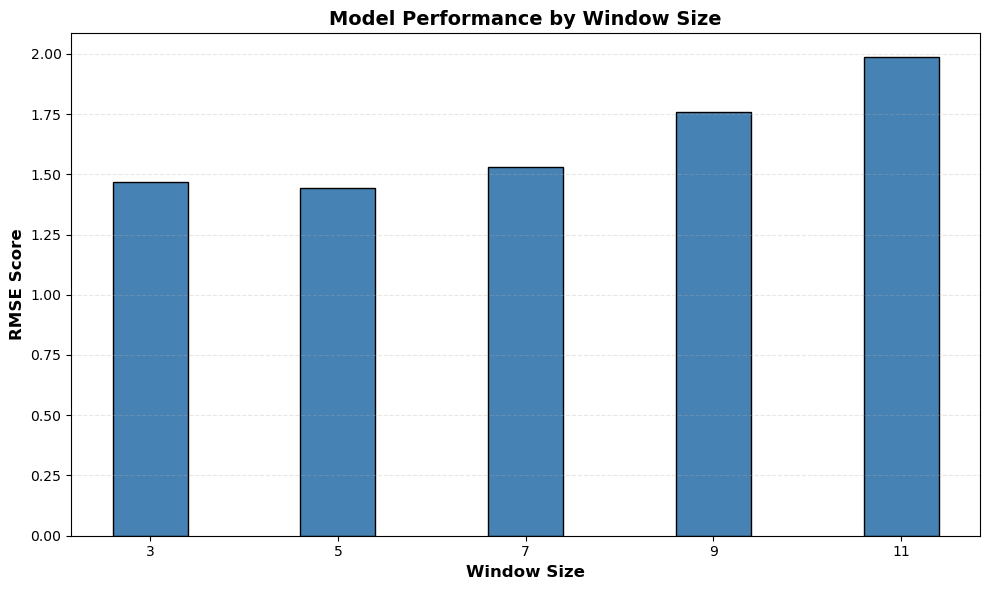

SUMMARY
Best Window Size: 5
Best RMSE Score: 1.4450


In [129]:
#stored weights and models
window_sizes = [3, 5, 7, 9, 11]
models = [model1, model2, model3, model4, model5]
weight_files = [
    './dnn/best_FCNNweights2.keras',
    './dnn/best_FCNNweights3.keras',
    './dnn/best_FCNNweights4.keras',
    './dnn/best_FCNNweights5.keras',
    './dnn/best_FCNNweights6.keras'
]
#test data
test_sets = [(x1_test, y1_test), (x2_test, y2_test), (x3_test, y3_test), 
             (x4_test, y4_test), (x5_test, y5_test)]

#storage for RMSE scores
scores = []

#recursively evaluate each model
for i, (ws, model, weights, (x_test, y_test)) in enumerate(zip(window_sizes, models, weight_files, test_sets)):
    print(f"\033[1m\033[4mWindow Size: {ws}\033[0m")
    model.load_weights(weights)
    y_pred = model.predict(x_test)
    print(y_pred.shape)
    
    #calculate RMSE
    score = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    scores.append(score)
    print(f"Score (RMSE): {score}")

#create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(window_sizes, scores, color='steelblue', edgecolor='black')

plt.xlabel('Window Size', fontsize=12, fontweight='bold')
plt.ylabel('RMSE Score', fontsize=12, fontweight='bold')
plt.title('Model Performance by Window Size', fontsize=14, fontweight='bold')
plt.xticks(window_sizes)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#data summary
print("SUMMARY")
best_idx = np.argmin(scores)
print(f"Best Window Size: {window_sizes[best_idx]}")
print(f"Best RMSE Score: {scores[best_idx]:.4f}")